# Anti Money Laundering (AML)

Money laundering is the process used to disguise the source of money or assets derived from criminal activity. Money laundering involves approximately $\$ 590$ billion to $\$ 1.5$ trillion USD per year worldwide. In 2018, $\$46.7$ billion was laundered through Canada with $\$7.4$ billion accounted in British Columbia. Canadian real state is a prime target for money laundering. For banks, it is important to comply the legislation from FINTRAC and OSFI. 

In terms of the model, it is important to reduce the false positive alarms while having very low tolerance to false negatives. False negatives, are critical because they may be problematic for the bank in terms of legislation and affect the reputation of the bank. It is important to analyze the context of the transactions/users relationships to improve effectiveness of the alarms. 



# Data: Elliptic Data Set

The [Elliptic Dataset](https://www.groundai.com/project/anti-money-laundering-in-bitcoin-experimenting-with-graph-convolutional-networks-for-financial-forensics/1) is a graph network of Bitcoin transactions with handcrafted features. All features are constructed using only publicly available information. 

The Elliptic DataSet maps Bitcoin transactions to real entities in two categories:
* Licit: exchanges, wallet providers, miners, licit services, etc.
* Ilicit: scams, malware, terrorist, organization, ransomware, Ponzi shcemes, etc

A given transaction is licit if the entity that generated it was licit.

- *Nodes and Edges* 203,769 node transactions and 234,355 directed edge payments flows. 2% are ilicit (Class 1), 21% are licit (Class 2)
- *Features* Each node has associated 166 features. 94 represent local information (timestep, number of inputs/outputs, transaction fee, output volume and aggregated figures) and 72 features represent aggregated features (obtained by aggregating transaction information such as maximum, minimum, standard deviation, correlation coefficients of neighbor transactions).
- *Temporal Information* A time step is associated with each node, representing an stimated of the time when the transaction is confirmed. There are 49 distinct timesteps evenly spaced with an interval of 2 weeks.


## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## Load Data

In [2]:
df_classes = pd.read_csv("/home/scypyuser/Desktop/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_edges = pd.read_csv("/home/scypyuser/Desktop/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_features = pd.read_csv("/home/scypyuser/Desktop/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

* Change column names

In [3]:
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

In [119]:
df_features = df_features.rename(columns=colNames)
df_features.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


* Change class 'unknown' to 3

In [5]:
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = 3
print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


<a id='eda'></a>
## Exploratory Data Analysis (EDA)

* Quantity of transactions per class

<BarContainer object of 3 artists>

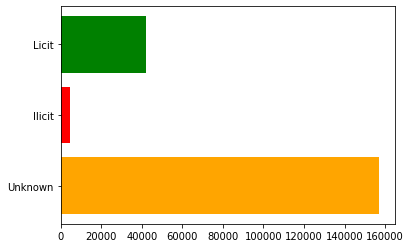

In [6]:
group_class = df_classes.groupby('class').count()
plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )

* Number of transactions per Time step

Text(0.5, 1.0, 'Number of transactions by Time step')

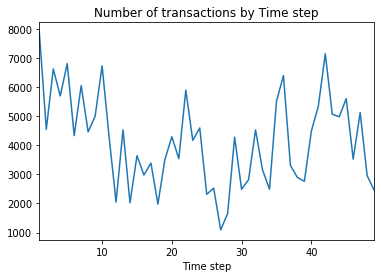

In [7]:
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')

* Number of transactions per class and timestep

In [8]:
# Merge Class and features
df_class_feature = pd.merge(df_classes, df_features )
df_class_feature.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [9]:
group_class_feature = df_class_feature.groupby(['Time step', 'class']).count()
#plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, color=['orange', 'r', 'g'] )
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})#unstack()
group_class_feature.head()

,Time step,class,count
0,1,3,5733
1,1,1,17
2,1,2,2130
3,2,3,3427
4,2,1,18


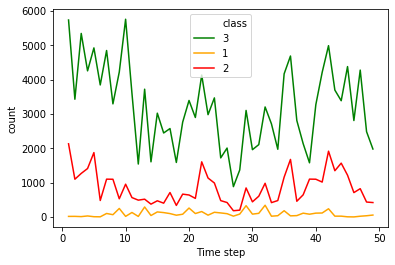

In [10]:
sns.lineplot(x='Time step', y='count', hue='class', data = group_class_feature, palette=['g', 'orange', 'r'] )

Text(0.5, 0, 'Time step')

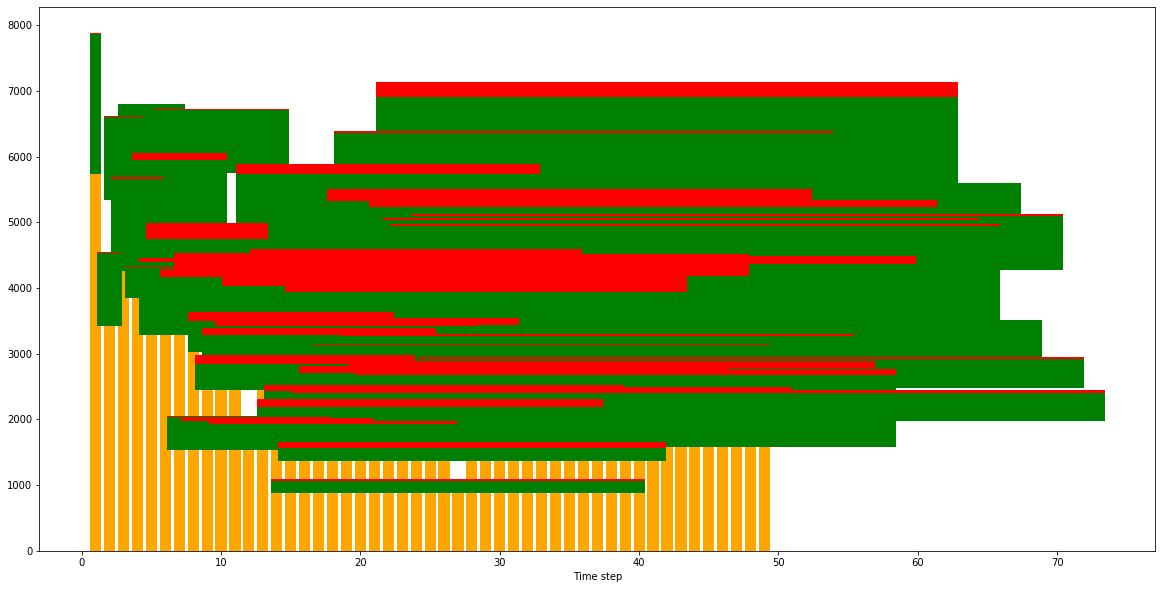

In [11]:
class1 = group_class_feature[group_class_feature['class'] == '1']
class2 = group_class_feature[group_class_feature['class'] == '2']
class3 = group_class_feature[group_class_feature['class'] == 3 ]

plt.figure(figsize=(20,10))

p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time step'], class2['count'], color='g',bottom=class3['count'])

p3 = plt.bar(class1['Time step'], class1['count'], color='r',bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('Time step')


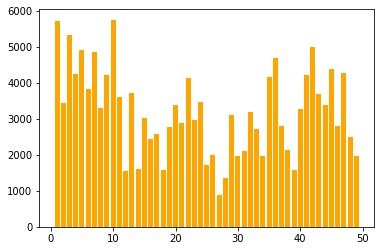

In [12]:
p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange')

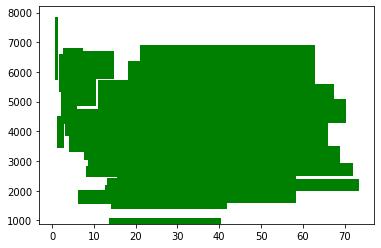

In [13]:
p2 = plt.bar(class2['Time step'], class2['count'], color='g',bottom=class3['count'])

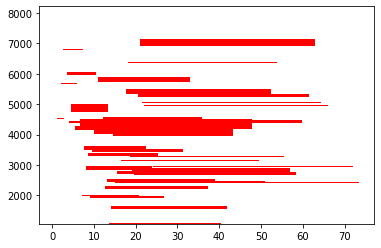

In [14]:
p3 = plt.bar(class1['Time step'], class1['count'], color='r',bottom=np.array(class3['count'])+np.array(class2['count']))

<a id='graphs'></a>
# Graphs
* Ilicit transactions at time step 20

/home/scypyuser/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/scypyuser/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


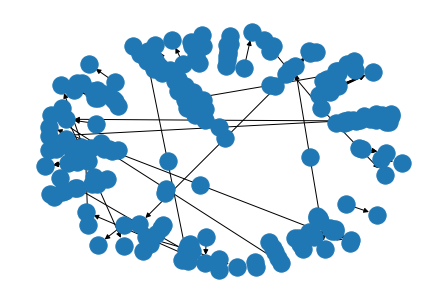

In [15]:
ilicit_ids = df_class_feature.loc[(df_class_feature['Time step'] == 20) & (df_class_feature['class'] == '1'), 'txId']
ilicit_edges = df_edges.loc[df_edges['txId1'].isin(ilicit_ids)]

graph = nx.from_pandas_edgelist(ilicit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)

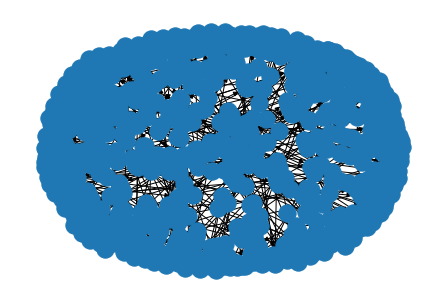

In [16]:
licit_ids = df_class_feature.loc[(df_class_feature['Time step'] == 20) & (df_class_feature['class'] == '2'), 'txId']
licit_edges = df_edges.loc[df_edges['txId1'].isin(licit_ids)]

graph = nx.from_pandas_edgelist(licit_edges, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=False, pos=pos)

<a id='prediction'></a>
# Prediction of ilicit transactions
## Import packages

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix,accuracy_score,classification_report,roc_auc_score,roc_curve,ConfusionMatrixDisplay

## Initial Data
* First we pick the class 1 or 2 transactions only

In [18]:
selected_ids = df_class_feature.loc[(df_class_feature['class'] != 3), 'txId']
df_edges_selected = df_edges.loc[df_edges['txId1'].isin(selected_ids)]
df_classes_selected = df_classes.loc[df_classes['txId'].isin(selected_ids)]
df_features_selected = df_features.loc[df_features['txId'].isin(selected_ids)]

# Merge Class and features
df_class_feature_selected = pd.merge(df_classes_selected, df_features_selected )
df_class_feature_selected.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,2,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,2,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,2,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,2,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [19]:
X = df_class_feature_selected.drop(columns=['txId', 'class', 'Time step']) # drop class, text id and time step
y = df_class_feature_selected[['class']]

# in this case, class 2 corresponds to licit transactions, we chang this to 0 as our interest is the ilicit transactions
y = y['class'].apply(lambda x: 0 if x == '2' else 1 )

In [20]:
X1 = df_class_feature_selected.drop(columns=[ 'class']) # drop class, text id and time step
y1 = df_class_feature_selected[['class']]

# in this case, class 2 corresponds to licit transactions, we chang this to 0 as our interest is the ilicit transactions
y1 = y1['class'].apply(lambda x: 0 if x == '2' else 1 )

In [21]:
df = pd.concat([X1,y1],axis=1)

In [22]:
df.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,class
0,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,0
1,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,0
2,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
3,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,0
4,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,0


* Split train/test data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=15)

## Random Forest Classifier

In [24]:
model_RF = RandomForestClassifier().fit(X_train,y_train)
y_preds = model_RF.predict(X_test)
prec,rec,f1,num = precision_recall_fscore_support(y_test, y_preds)

print("Random Forest Classifier")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))

Random Forest Classifier
Precision:0.997 
Recall:0.885 
F1 Score:0.937


In [25]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10523
           1       1.00      0.88      0.94      1118

    accuracy                           0.99     11641
   macro avg       0.99      0.94      0.97     11641
weighted avg       0.99      0.99      0.99     11641



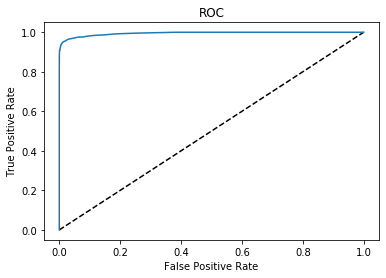

In [26]:
y_pred_prob_rf = model_RF.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob_rf)
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [27]:
roc_auc_score(y_test,y_preds)

0.9421651474060483

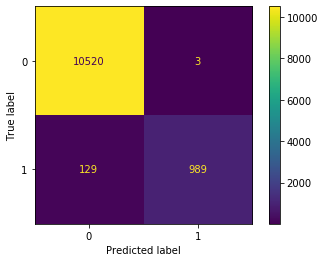

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test,y_preds)

In [85]:
#from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestCentroid
from sklearn.svm import NuSVC
from sklearn.linear_model import Perceptron

In [96]:
def get_models():
    models = list()
    models.append(LogisticRegression())
      # models.append(RidgeClassifier())
      # models.append(SGDClassifier())
      # models.append(PassiveAggressiveClassifier())
    models.append(KNeighborsClassifier())
    models.append(DecisionTreeClassifier())
    models.append(ExtraTreeClassifier())
      # models.append(LinearSVC())
    models.append(SVC(probability=True))
    models.append(GaussianNB())
    models.append(AdaBoostClassifier())
    models.append(BaggingClassifier())
    models.append(RandomForestClassifier())
    models.append(ExtraTreesClassifier())
    models.append(GaussianProcessClassifier())
    models.append(GradientBoostingClassifier())
    models.append(LinearDiscriminantAnalysis())
    models.append(QuadraticDiscriminantAnalysis())
    #models.append(OneClassSVM())
    models.append(MLPClassifier())
    #models.append(RadiusNeighborsClassifier())
    #models.append(RidgeClassifierCV())
    models.append(BernoulliNB())
    models.append(CalibratedClassifierCV())
    models.append(GaussianNB())
      ##models.append(LabelPropagation())
      #models.append(MultinomialNB())
    models.append(LogisticRegressionCV())
      ##models.append(LabelSpreading())
      ##models.append(NearestCentroid())
      #models.append(NuSVC())
      #models.append(Perceptron())
    #models.append(LGBMClassifier())
    models.append(CatBoostClassifier())
    #models.append(XGBClassifier())
    return models

In [99]:
models = get_models()

LogisticRegression() starting


/home/scypyuser/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/scypyuser/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression() fitted
LogisticRegression() done
[[62876   409]
 [ 2886  1073]]
The Precision of  LogisticRegression() is  [0.95611447 0.72402159]
The Accuracy score of LogisticRegression() is 0.9509993456665279
The F1 score of  LogisticRegression() is 0.3944127917662194
ROC_AUC score 0.6322826052444844
Classification Report of LogisticRegression() is 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     63285
           1       0.72      0.27      0.39      3959

    accuracy                           0.95     67244
   macro avg       0.84      0.63      0.68     67244
weighted avg       0.94      0.95      0.94     67244

KNeighborsClassifier() starting
KNeighborsClassifier() fitted
KNeighborsClassifier() done


/home/scypyuser/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[[62473   812]
 [  910  3049]]
The Precision of  KNeighborsClassifier() is  [0.98564284 0.78969179]
The Accuracy score of KNeighborsClassifier() is 0.9743917672952234
The F1 score of  KNeighborsClassifier() is 0.7797953964194373
ROC_AUC score 0.8786565655797636
Classification Report of KNeighborsClassifier() is 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     63285
           1       0.79      0.77      0.78      3959

    accuracy                           0.97     67244
   macro avg       0.89      0.88      0.88     67244
weighted avg       0.97      0.97      0.97     67244

DecisionTreeClassifier() starting
DecisionTreeClassifier() fitted
DecisionTreeClassifier() done
[[62740   545]
 [  450  3509]]
The Precision of  DecisionTreeClassifier() is  [0.99287862 0.86556487]
The Accuracy score of DecisionTreeClassifier() is 0.9852031408006662
The F1 score of  DecisionTreeClassifier() is 0.8758267814800947
ROC_AUC score 0.93886154885

/home/scypyuser/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(probability=True) fitted
SVC(probability=True) done
[[62458   827]
 [  950  3009]]
The Precision of  SVC(probability=True) is  [0.98501766 0.78441084]
The Accuracy score of SVC(probability=True) is 0.9735738504550592
The F1 score of  SVC(probability=True) is 0.7720333547145607
ROC_AUC score 0.8734862733314331
Classification Report of SVC(probability=True) is 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     63285
           1       0.78      0.76      0.77      3959

    accuracy                           0.97     67244
   macro avg       0.88      0.87      0.88     67244
weighted avg       0.97      0.97      0.97     67244

GaussianNB() starting


/home/scypyuser/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB() fitted
GaussianNB() done
[[24999 38286]
 [  251  3708]]
The Precision of  GaussianNB() is  [0.99005941 0.08829833]
The Accuracy score of GaussianNB() is 0.42690797691987387
The F1 score of  GaussianNB() is 0.16138228189672058
ROC_AUC score 0.6658113343687947
Classification Report of GaussianNB() is 
               precision    recall  f1-score   support

           0       0.99      0.40      0.56     63285
           1       0.09      0.94      0.16      3959

    accuracy                           0.43     67244
   macro avg       0.54      0.67      0.36     67244
weighted avg       0.94      0.43      0.54     67244

AdaBoostClassifier() starting


/home/scypyuser/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier() fitted
AdaBoostClassifier() done
[[62644   641]
 [  892  3067]]
The Precision of  AdaBoostClassifier() is  [0.98596072 0.82713053]
The Accuracy score of AdaBoostClassifier() is 0.977202426982333
The F1 score of  AdaBoostClassifier() is 0.8000521716447111
ROC_AUC score 0.8822808979684972
Classification Report of AdaBoostClassifier() is 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     63285
           1       0.83      0.77      0.80      3959

    accuracy                           0.98     67244
   macro avg       0.91      0.88      0.89     67244
weighted avg       0.98      0.98      0.98     67244

BaggingClassifier() starting


/home/scypyuser/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier() fitted
BaggingClassifier() done
[[63140   145]
 [  493  3466]]
The Precision of  BaggingClassifier() is  [0.99225245 0.95984492]
The Accuracy score of BaggingClassifier() is 0.9905121646540955
The F1 score of  BaggingClassifier() is 0.9157199471598414
ROC_AUC score 0.9365911910985044
Classification Report of BaggingClassifier() is 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     63285
           1       0.96      0.88      0.92      3959

    accuracy                           0.99     67244
   macro avg       0.98      0.94      0.96     67244
weighted avg       0.99      0.99      0.99     67244

RandomForestClassifier() starting


/home/scypyuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier() fitted
RandomForestClassifier() done
[[63186    99]
 [  498  3461]]
The Precision of  RandomForestClassifier() is  [0.99218014 0.97219101]
The Accuracy score of RandomForestClassifier() is 0.9911218844803997
The F1 score of  RandomForestClassifier() is 0.9206011437691184
ROC_AUC score 0.9363231537576346
Classification Report of RandomForestClassifier() is 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     63285
           1       0.97      0.87      0.92      3959

    accuracy                           0.99     67244
   macro avg       0.98      0.94      0.96     67244
weighted avg       0.99      0.99      0.99     67244

ExtraTreesClassifier() starting


/home/scypyuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


ExtraTreesClassifier() fitted
ExtraTreesClassifier() done
[[63076   209]
 [  585  3374]]
The Precision of  ExtraTreesClassifier() is  [0.9908107  0.94166899]
The Accuracy score of ExtraTreesClassifier() is 0.9881922550710844
The F1 score of  ExtraTreesClassifier() is 0.8947228851763458
ROC_AUC score 0.9244664463193015
Classification Report of ExtraTreesClassifier() is 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     63285
           1       0.94      0.85      0.89      3959

    accuracy                           0.99     67244
   macro avg       0.97      0.92      0.94     67244
weighted avg       0.99      0.99      0.99     67244

GaussianProcessClassifier() starting


/home/scypyuser/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MemoryError: 

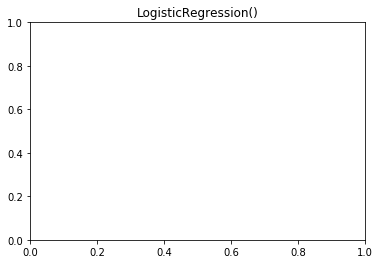

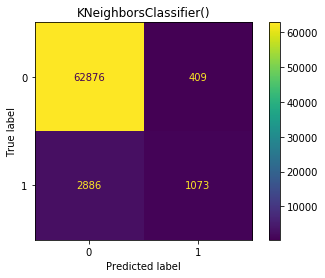

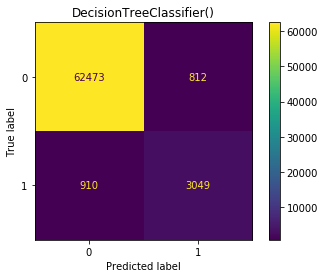

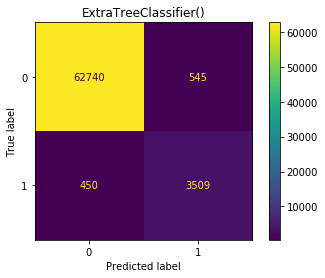

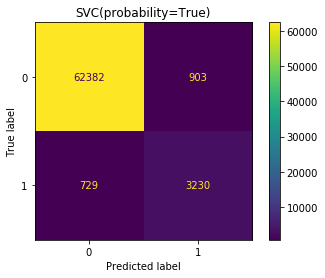

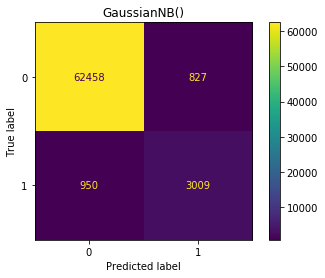

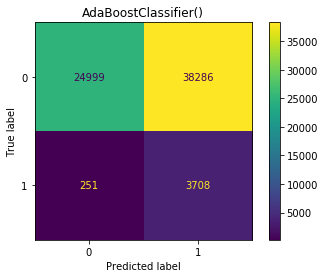

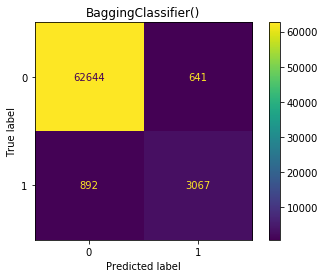

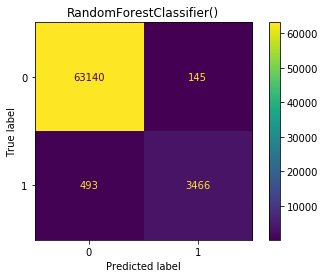

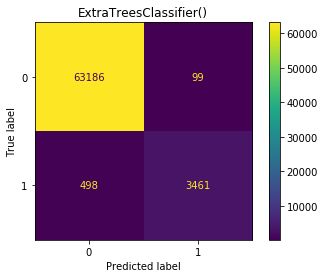

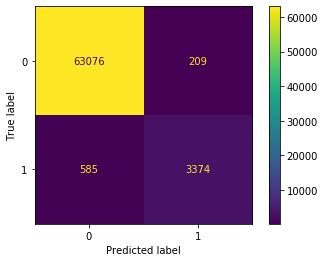

In [100]:
for model in models:
    print(model,"starting")
    package = model.fit(X_train, y_train)
    print(model,"fitted")
    print(package,"done")
    y_predict = package.predict(X_test)
    y_pred1 = package.predict_proba(X_test)
    cm = confusion_matrix(y_test, y_predict)
    print(cm)
    #tn,fp,fn,tp = cm.ravel()
    # print(tn)
  # print(fp)
  # print(fn)
  # print(tp)
  #precision = tp / (tp + fp)
    precision = precision_score(y_test,y_predict,average=None)
    print("The Precision of ",model,"is ",precision)
  #recall = tp / (tp + fn)
  #print("the recall is ",recall)
  #specificity = tn / (tn+fp)
  #print("the specificity is ",specificity)
    print("The Accuracy score of",model,"is",accuracy_score(y_test, y_predict))
    print("The F1 score of ",model,"is",f1_score(y_test,y_predict))
    #print("ROC AUC score of ",model,"is",roc_auc_score(y_test,y_pred1,multi_class='ovr',average= 'weighted'))
    print("ROC_AUC score",roc_auc_score(y_test,y_predict))
    print("Classification Report of",model,"is \n",classification_report(y_test, y_predict))
    plt.title(model)
    ConfusionMatrixDisplay.from_predictions(y_test,y_predict);

## Predicting 'unknown' transactions
* Selecting 'unknown' ids

In [29]:
unknown_ids = df_class_feature.loc[(df_class_feature['class'] == 3), 'txId']

df_edges_unknown = df_edges.loc[df_edges['txId1'].isin(unknown_ids)]
df_classes_unknown = df_classes.loc[df_classes['txId'].isin(unknown_ids)]
df_features_unknown = df_features.loc[df_features['txId'].isin(unknown_ids)]

* Predicting Class

In [30]:
X_unknown = df_features_unknown.drop(columns=['txId', 'Time step'])
y_unknown_preds = model_RF.predict(X_unknown)

In [31]:
y_unknown_preds

array([0, 0, 0, ..., 0, 0, 0])

* Replacing 'unknown' class with the predicted one

In [32]:
df_classes_unknown = df_classes_unknown.copy()
df_classes_unknown.loc[:, 'class'] = y_unknown_preds

* Merge class and features

In [33]:
df_class_feature_unknown = pd.merge(df_classes_unknown, df_features_unknown )
df_class_feature_unknown.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,0,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [68]:
final_data = pd.concat([df_class_feature_unknown,df],axis=0,sort=False)

In [225]:
final_data2=final_data[:20000]

In [226]:
final_data2.shape

(20000, 168)

In [69]:
final_data.shape

(203769, 168)

In [227]:
final_data2.to_csv('AntiMoneyLaundering1.csv')

In [70]:
final_data.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,0,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,0,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,0,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,230460314,0,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
4,230459870,0,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540


In [71]:
x = final_data.drop(['Time step','txId','class'],axis=1)

In [72]:
y = final_data[['class']]

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [75]:
X_train_num = X_train.to_numpy()
X_test_num = X_test.to_numpy()

y_train_num = y_train.to_numpy()
y_test_num = y_test.to_numpy()

In [218]:
# KFOLD

In [221]:
from sklearn.model_selection import StratifiedKFold,cross_val_score

In [220]:
cv = StratifiedKFold(n_splits=10)

In [222]:
m_cv = cross_val_score(RandomForestClassifier(),x,y,cv = cv,n_jobs=-1)

In [76]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adamax, Adam, RMSprop, SGD

In [107]:
# Dense -> adding Hidden input layers
ann = tf.keras.models.Sequential()
# ann_variable = Sequential()
ann.add(tf.keras.layers.Dense(units=8,activation='relu'))

ann.add(tf.keras.layers.Dense(units=8,activation='relu'))

ann.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

ann.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [114]:
ann.fit(X_train,y_train,batch_size=32,epochs=20)

Epoch 1/20
4267/4267 [==============================] - 3s 812us/step - loss: 0.0885 - accuracy: 0.9777
Epoch 2/20
4267/4267 [==============================] - 3s 801us/step - loss: 0.0857 - accuracy: 0.9776
Epoch 3/20
4267/4267 [==============================] - 4s 840us/step - loss: 0.0870 - accuracy: 0.9778
Epoch 4/20
4267/4267 [==============================] - 4s 883us/step - loss: 0.0870 - accuracy: 0.9776
Epoch 5/20
4267/4267 [==============================] - 3s 734us/step - loss: 0.0874 - accuracy: 0.9777
Epoch 6/20
4267/4267 [==============================] - 3s 726us/step - loss: 0.0867 - accuracy: 0.9776
Epoch 7/20
4267/4267 [==============================] - 4s 825us/step - loss: 0.0870 - accuracy: 0.9776
Epoch 8/20
4267/4267 [==============================] - 3s 815us/step - loss: 0.0884 - accuracy: 0.9776
Epoch 9/20
4267/4267 [==============================] - 3s 773us/step - loss: 0.0885 - accuracy: 0.9774
Epoch 10/20
4267/4267 [==============================] - 3s 728u

In [187]:
y_predict = ann.predict(X_test_num)

In [189]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report,roc_auc_score,plot_roc_curve,roc_curve,ConfusionMatrixDisplay,precision_score

Precision: [0.98445352 0.83305275]
Accuracy: 0.976429123787996
F1 score: 0.976429123787996
ROC_AUC score 0.8702674703775641
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.99      0.99     63285
           1       0.83      0.75      0.79      3959

    accuracy                           0.98     67244
   macro avg       0.91      0.87      0.89     67244
weighted avg       0.98      0.98      0.98     67244

Confusion Matrix:


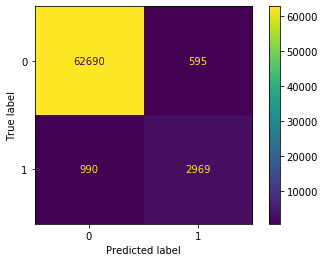

In [190]:
#cm = confusion_matrix(y_test_num, y_predict)
#print(cm)
    #tn,fp,fn,tp = cm.ravel()
    # print(tn)
  # print(fp)
  # print(fn)
  # print(tp)
  #precision = tp / (tp + fp)
precision = precision_score(y_test_num,y_predict,average=None)
print("Precision:",precision)
  #recall = tp / (tp + fn)
  #print("the recall is ",recall)
  #specificity = tn / (tn+fp)
  #print("the specificity is ",specificity)
print("Accuracy:",accuracy_score(y_test_num, y_predict))
print("F1 score:",f1_score(y_test_num,y_predict,average='micro'))
#print("ROC AUC score of ",ann,"is",roc_auc_score(y_test_num,y_pred1,multi_class='ovr',average= 'weighted'))
print("ROC_AUC score",roc_auc_score(y_test_num,y_predict))
print("Classification Report:",classification_report(y_test_num, y_predict))
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_num,y_predict);

In [ ]:
# CNN

In [124]:
X_train = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1], 1)
X_test = X_test_num.reshape(X_test_num.shape[0], X_test_num.shape[1], 1)

In [163]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D,LSTM,SimpleRNN
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.7.0


In [149]:
model1 = Sequential()

model1.add(Conv1D(32, 2, activation='relu', input_shape = X_train[0].shape))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))

model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(1, activation='sigmoid'))

In [150]:
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 164, 32)           96        
                                                                 
 batch_normalization_4 (Batc  (None, 164, 32)          128       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 164, 32)           0         
                                                                 
 flatten_2 (Flatten)         (None, 5248)              0         
                                                                 
 dense_15 (Dense)            (None, 64)                335936    
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                      

In [151]:
model1.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [152]:
model1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test_num), verbose=1)

Epoch 1/10
4267/4267 [==============================] - 29s 7ms/step - loss: 0.1125 - accuracy: 0.9681 - val_loss: 0.0811 - val_accuracy: 0.9731
Epoch 2/10
4267/4267 [==============================] - 28s 7ms/step - loss: 0.0878 - accuracy: 0.9729 - val_loss: 0.0712 - val_accuracy: 0.9762
Epoch 3/10
4267/4267 [==============================] - 27s 6ms/step - loss: 0.0802 - accuracy: 0.9743 - val_loss: 0.0673 - val_accuracy: 0.9773
Epoch 4/10
4267/4267 [==============================] - 27s 6ms/step - loss: 0.0765 - accuracy: 0.9753 - val_loss: 0.0645 - val_accuracy: 0.9784
Epoch 5/10
4267/4267 [==============================] - 28s 6ms/step - loss: 0.0752 - accuracy: 0.9760 - val_loss: 0.0643 - val_accuracy: 0.9793
Epoch 6/10
4267/4267 [==============================] - 27s 6ms/step - loss: 0.0727 - accuracy: 0.9769 - val_loss: 0.0587 - val_accuracy: 0.9810
Epoch 7/10
4267/4267 [==============================] - 27s 6ms/step - loss: 0.0705 - accuracy: 0.9770 - val_loss: 0.0584 - val_ac

In [185]:
y_predict = model1.predict(X_test)

In [186]:
y_predict = (y_predict > 0.5)

Precision: [0.98601388 0.86715659]
Accuracy: 0.9797602760097556
F1 score: 0.9797602760097556
ROC_AUC score 0.8837582235373269
Classification Report:               precision    recall  f1-score   support

           0       0.99      0.99      0.99     63285
           1       0.87      0.77      0.82      3959

    accuracy                           0.98     67244
   macro avg       0.93      0.88      0.90     67244
weighted avg       0.98      0.98      0.98     67244

Confusion Matrix:


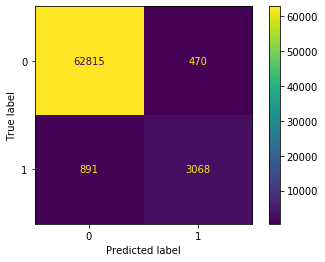

In [155]:
#cm = confusion_matrix(y_test_num, y_predict)
#print(cm)
    #tn,fp,fn,tp = cm.ravel()
    # print(tn)
  # print(fp)
  # print(fn)
  # print(tp)
  #precision = tp / (tp + fp)
precision = precision_score(y_test_num,y_predict,average=None)
print("Precision:",precision)
  #recall = tp / (tp + fn)
  #print("the recall is ",recall)
  #specificity = tn / (tn+fp)
  #print("the specificity is ",specificity)
print("Accuracy:",accuracy_score(y_test_num, y_predict))
print("F1 score:",f1_score(y_test_num,y_predict,average='micro'))
#print("ROC AUC score of ",ann,"is",roc_auc_score(y_test_num,y_pred1,multi_class='ovr',average= 'weighted'))
print("ROC_AUC score",roc_auc_score(y_test_num,y_predict))
print("Classification Report:",classification_report(y_test_num, y_predict))
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_num,y_predict);

In [156]:
# LSTM

In [200]:
model2 = Sequential()
model2.add(LSTM(32, activation='tanh', input_shape = X_train[0].shape))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

In [201]:
model2.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [202]:
model2.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test_num), verbose=1)

Epoch 1/5
4267/4267 [==============================] - 160s 37ms/step - loss: 0.2510 - accuracy: 0.9388 - val_loss: 0.2219 - val_accuracy: 0.9411
Epoch 2/5
4267/4267 [==============================] - 156s 37ms/step - loss: 0.2231 - accuracy: 0.9407 - val_loss: 0.1843 - val_accuracy: 0.9411
Epoch 3/5
4267/4267 [==============================] - 158s 37ms/step - loss: 0.1728 - accuracy: 0.9407 - val_loss: 0.1819 - val_accuracy: 0.9411
Epoch 4/5
4267/4267 [==============================] - 157s 37ms/step - loss: 0.1709 - accuracy: 0.9407 - val_loss: 0.2142 - val_accuracy: 0.9411
Epoch 5/5
4267/4267 [==============================] - 158s 37ms/step - loss: 0.1892 - accuracy: 0.9427 - val_loss: 0.1315 - val_accuracy: 0.9539


In [205]:
y_predict = model2.predict(X_test)

In [215]:
y_predict[y_predict >0.5].shape

(1988,)

In [ ]:
y_predict = (y_predict > 0.5)

Precision: [0.96113767 0.71579477]
Accuracy: 0.9538843614300161
F1 score: 0.9538843614300161
ROC_AUC score 0.6752531672763468
Classification Report:               precision    recall  f1-score   support

           0       0.96      0.99      0.98     63285
           1       0.72      0.36      0.48      3959

    accuracy                           0.95     67244
   macro avg       0.84      0.68      0.73     67244
weighted avg       0.95      0.95      0.95     67244

Confusion Matrix:


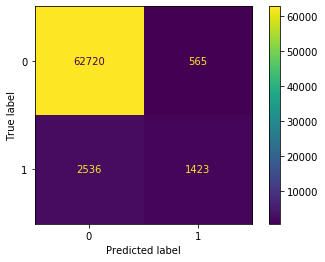

In [204]:
#cm = confusion_matrix(y_test_num, y_predict)
#print(cm)
    #tn,fp,fn,tp = cm.ravel()
    # print(tn)
  # print(fp)
  # print(fn)
  # print(tp)
  #precision = tp / (tp + fp)
precision = precision_score(y_test_num,y_predict,average=None)
print("Precision:",precision)
  #recall = tp / (tp + fn)
  #print("the recall is ",recall)
  #specificity = tn / (tn+fp)
  #print("the specificity is ",specificity)
print("Accuracy:",accuracy_score(y_test_num, y_predict))
print("F1 score:",f1_score(y_test_num,y_predict,average='micro'))
#print("ROC AUC score of ",ann,"is",roc_auc_score(y_test_num,y_pred1,multi_class='ovr',average= 'weighted'))
print("ROC_AUC score",roc_auc_score(y_test_num,y_predict))
print("Classification Report:",classification_report(y_test_num, y_predict))
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_num,y_predict);

In [169]:
model3 = Sequential()
model3.add(SimpleRNN(32,activation='relu',input_shape=X_train[0].shape))
model3.add(Dropout(0.4))
model3.add(Dense(32,activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(32,activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(1,activation='sigmoid'))

In [170]:
model3.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [171]:
model3.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test_num), verbose=1)

Epoch 1/5
4267/4267 [==============================] - 85s 20ms/step - loss: 0.2155 - accuracy: 0.9351 - val_loss: 0.1439 - val_accuracy: 0.9411
Epoch 2/5
4267/4267 [==============================] - 84s 20ms/step - loss: 0.1458 - accuracy: 0.9407 - val_loss: 0.1374 - val_accuracy: 0.9411
Epoch 3/5
4267/4267 [==============================] - 86s 20ms/step - loss: 0.1405 - accuracy: 0.9440 - val_loss: 0.1386 - val_accuracy: 0.9555
Epoch 4/5
4267/4267 [==============================] - 85s 20ms/step - loss: 0.1368 - accuracy: 0.9573 - val_loss: 0.1536 - val_accuracy: 0.9613
Epoch 5/5
4267/4267 [==============================] - 85s 20ms/step - loss: 0.1359 - accuracy: 0.9616 - val_loss: 0.1370 - val_accuracy: 0.9621


In [216]:
y_predict = model3.predict(X_test)
y_predict = (y_predict > 0.5)

Precision: [0.98113118 0.67119302]
Accuracy: 0.9621230146927607
F1 score: 0.9621230146927607
ROC_AUC score 0.8388697888842982
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.98      0.98     63285
           1       0.67      0.70      0.68      3959

    accuracy                           0.96     67244
   macro avg       0.83      0.84      0.83     67244
weighted avg       0.96      0.96      0.96     67244

Confusion Matrix:


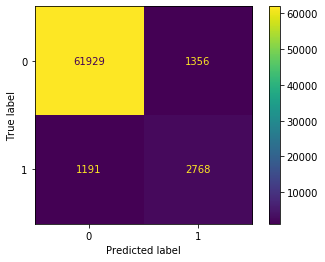

In [217]:
#cm = confusion_matrix(y_test_num, y_predict)
#print(cm)
    #tn,fp,fn,tp = cm.ravel()
    # print(tn)
  # print(fp)
  # print(fn)
  # print(tp)
  #precision = tp / (tp + fp)
precision = precision_score(y_test_num,y_predict,average=None)
print("Precision:",precision)
  #recall = tp / (tp + fn)
  #print("the recall is ",recall)
  #specificity = tn / (tn+fp)
  #print("the specificity is ",specificity)
print("Accuracy:",accuracy_score(y_test_num, y_predict))
print("F1 score:",f1_score(y_test_num,y_predict,average='micro'))
#print("ROC AUC score of ",ann,"is",roc_auc_score(y_test_num,y_pred1,multi_class='ovr',average= 'weighted'))
print("ROC_AUC score",roc_auc_score(y_test_num,y_predict))
print("Classification Report:",classification_report(y_test_num, y_predict))
print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_test_num,y_predict);